In [246]:
import scipy.io.wavfile as wav
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sounddevice as sd
from python_speech_features import mfcc, sigproc
from sklearn.mixture import GaussianMixture as GMM
import numpy as np

In [247]:
# Load audio
rate, signal = wav.read("../recordings/wav/gordon_trillanes.wav")

In [248]:
start_seconds = 10
end_seconds = 30
signal = signal[rate * start_seconds : rate * end_seconds]

print("Rate: {0}".format(rate))
print("Seconds: {0}".format(end_seconds - start_seconds))

Rate: 44100
Seconds: 20


In [249]:
sd.play(signal, rate)

In [250]:
sd.stop()

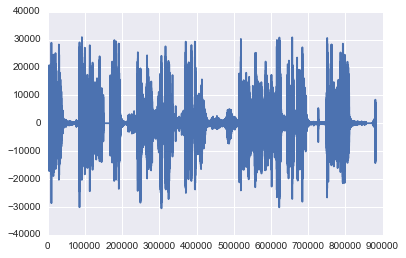

In [251]:
plt.plot(signal)
plt.show()

In [252]:
winlen = 0.025
winstep = 0.025
mfcc_feat = mfcc(signal, rate, winlen, winstep, nfft=2048)

In [253]:
# get min no of components
def get_min_components(feats):
    comps = np.arange(2, 30)
    models = [GMM(n, covariance_type='full', random_state=0).fit(feats)
              for n in comps]
    bics = [m.bic(feats) for m in models]
    return np.argmin(bics)

In [254]:
n_components = 3
gmm = GMM(n_components=n_components, covariance_type='full')

In [255]:
labels = gmm.fit(mfcc_feat).predict(mfcc_feat)

In [256]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0,
       0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1,

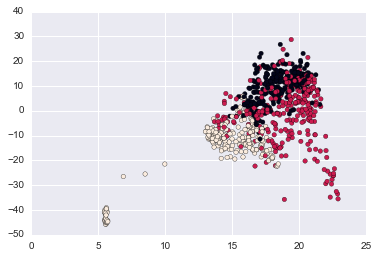

In [257]:
plt.scatter(mfcc_feat[:, 0], mfcc_feat[:, 1], c=labels)
plt.show()

In [258]:
framed_signal = sigproc.framesig(signal, winlen*rate, winstep*rate)

In [259]:
separated = framed_signal[np.where(labels==0)].ravel()
for i in range(1, n_components):
    segmented = framed_signal[np.where(labels==i)].ravel()
    separated = np.concatenate((separated, segmented))
separated.shape

(882400,)

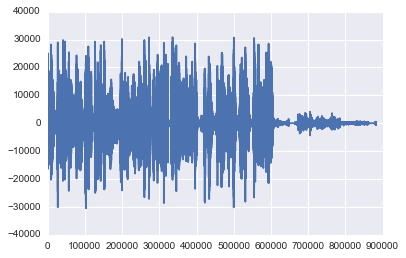

In [260]:
plt.plot(separated)
plt.show()

In [261]:
sd.play(separated, rate)

In [262]:
sd.stop()

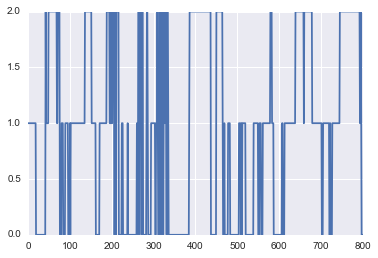

In [263]:
plt.plot(labels)
plt.show()

Unvoiced Label: 2


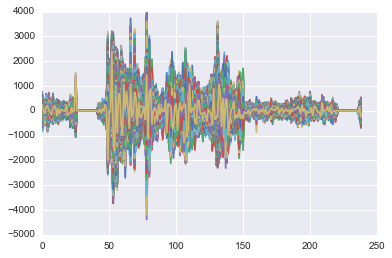

In [264]:
# identify which label is for unvoiced/silent segments
unvoiced_label = 0
for i in range(1, n_components):
    cur_unvoiced_mean = np.mean(abs(framed_signal[np.where(labels == unvoiced_label)]))
    temp_unvoiced_mean = np.mean(abs(framed_signal[np.where(labels == i)]))
    if cur_unvoiced_mean > temp_unvoiced_mean:
        unvoiced_label = i
print("Unvoiced Label: {0}".format(unvoiced_label))
unvoiced_idx = np.where(labels == unvoiced_label)
plt.plot(framed_signal[unvoiced_idx])
plt.show()

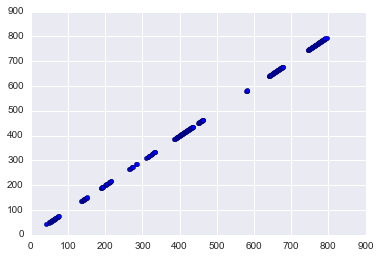

In [265]:
# aggregate and replace the unvoice
plt.scatter(unvoiced_idx, unvoiced_idx)
plt.show()
unvoiced = np.array(unvoiced_idx).ravel().reshape(-1, 1)

In [266]:
n_components = get_min_components(unvoiced)
print("No. of components for unvoiced: {0}".format(n_components))

No. of components for unvoiced: 8


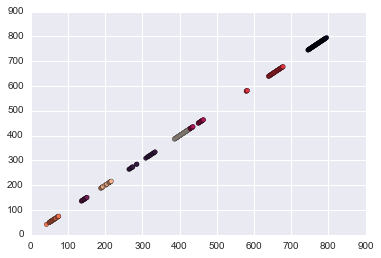

In [268]:
gmm_unvoiced = GMM(n_components=n_components, covariance_type='full')
labels_unvoiced = gmm_unvoiced.fit(unvoiced).predict(unvoiced)

plt.scatter(unvoiced, unvoiced, c=labels_unvoiced)
plt.show()

In [269]:
# Speeches per speaker
separated = np.array([])
for i in range(0, 3):
    if i == unvoiced_label:
        continue
    i_idx = np.array(np.where(labels == i)).reshape(-1, 1)
    segmented_idx = np.sort(np.concatenate((i_idx, unvoiced)).ravel())
    segmented = framed_signal[segmented_idx].ravel()
    print("I: {0}, segmented: {1}".format(i, segmented))
    separated = np.concatenate((separated, segmented))

I: 0, segmented: [ 14900.  15155.  16190. ...,      0.      0.      0.]
I: 1, segmented: [-1998. -1966. -1948. ...,   -53.   -18.   -30.]


Samples: 1146017
Seconds: 25.986780045351473


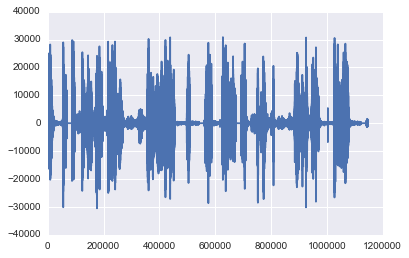

In [270]:
print("Samples:", len(separated))
print("Seconds:", len(separated)/rate)
plt.plot(separated)
plt.show()

In [271]:
sd.play(separated, rate)

In [ ]:
sd.stop()

In [ ]:
plt.plot(framed_signal[0])
plt.show()